In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import sys
sys.path.append("/ahg/regevdata/projects/Cell2CellCommunication/code/MIMOSCA")
import perturbseq as perturb


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:

DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


Gene sizes
==

- extract principal transcript from APPRIS
- if multiple, take max length

In [3]:
#read list of cancer genes
cancer_f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/data/foundation_genes.txt'
cancer_genes=list(pd.read_csv(cancer_f,header=None).loc[:,0])
print(cancer_genes)
print(len(cancer_genes))

#assign each gene to a principal transcript
appris_f='/ahg/regevdata/projects/Cell2CellCommunication/data/genomes/hg38/translated/appris_data.principal.txt'

gene_transcripts={}
for line in open(appris_f,'r').readlines():
    items=line.strip().split('\t')
    if 'PRINCIPAL' in items[4]:
        gene=items[0]
        transcript=items[2]
        if gene not in gene_transcripts:
            gene_transcripts[gene]=[]
        gene_transcripts[gene].append(transcript)
        
print(len(list(set(gene_transcripts.keys()).intersection(set(cancer_genes)))))
print('missed',list(set(cancer_genes).difference(set(gene_transcripts.keys()))))

['ABL1', 'ACVR1B', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'ALOX12B', 'AMER1', 'FAM123B', 'APC', 'AR', 'ARAF', 'ARFRP1', 'ARID1A', 'ASXL1', 'ATM', 'ATR', 'ATRX', 'AURKA', 'AURKB', 'AXIN1', 'AXL', 'BAP1', 'BARD1', 'BCL2', 'BCL2L1', 'BCL2L2', 'BCL6', 'BCOR', 'BCORL1', 'BRAF', 'BRCA1', 'BRCA2', 'BRD4', 'BRIP1', 'BTG1', 'BTG2', 'BTK', 'C11orf30', 'EMSY', 'CALR', 'CARD11', 'CASP8', 'CBFB', 'CBL', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CD22', 'CD274', 'PD-L1', 'CD70', 'CD79A', 'CD79B', 'CDC73', 'CDH1', 'CDK12', 'CDK4', 'CDK6', 'CDK8', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CEBPA', 'CHEK1', 'CHEK2', 'CIC', 'CREBBP', 'CRKL', 'CSF1R', 'CSF3R', 'CTCF', 'CTNNA1', 'CTNNB1', 'CUL3', 'CUL4A', 'CXCR4', 'CYP17A1', 'DAXX', 'DDR1', 'DDR2', 'DIS3', 'DNMT3A', 'DOT1L', 'EED', 'EGFR', 'EP300', 'EPHA3', 'EPHB1', 'EPHB4', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC4', 'ERG', 'ERRFI1', 'ESR1', 'EZH2', 'FAM46C', 'FANCA', 'FANCC', 'FANCG', 'FANCL', 'FAS', 'FBXW7', 'FGF10', 'FGF12', 'FGF14', 'FGF19', 'FGF23', 'FGF3', 'FGF4

In [4]:
#we'll need to manually figure out the gene symbols for these
d={}
d['FAM123B']='AMER1'
d['WHSC1']='NSD2'
d['H3F3A']='H3-3A'
d['FAM46C']='TENT5C'
d['MLL']='KMT2A'
d['C17orf39']='GID4'
d['PD-L2']='PDCD1LG2'
d['C11orf30']='EMSY'
d['MEK1']='MAP2K1'
d['MYCL1']='MYCL'
d['PD-1']='PDCD1'
d['PD-L1']='CD274'
d['MLL2']='KMT2D'
d['MMSET']='NSD2'
d['WHSC1L1']='NSD3'
d['MRE11A']='MRE11'
d['PARK2']='PRKN'
d['MEK2']='MAP2K2'
for gene in list(set(gene_transcripts.keys()).intersection(set(cancer_genes))):
    d[gene]=gene
print(d)

remapped=[]
for gene in d:
    remapped.append(d[gene])
print(len(remapped))

{'FAM123B': 'AMER1', 'WHSC1': 'NSD2', 'H3F3A': 'H3-3A', 'FAM46C': 'TENT5C', 'MLL': 'KMT2A', 'C17orf39': 'GID4', 'PD-L2': 'PDCD1LG2', 'C11orf30': 'EMSY', 'MEK1': 'MAP2K1', 'MYCL1': 'MYCL', 'PD-1': 'PDCD1', 'PD-L1': 'CD274', 'MLL2': 'KMT2D', 'MMSET': 'NSD2', 'WHSC1L1': 'NSD3', 'MRE11A': 'MRE11', 'PARK2': 'PRKN', 'MEK2': 'MAP2K2', 'SOX9': 'SOX9', 'CD274': 'CD274', 'DIS3': 'DIS3', 'SPOP': 'SPOP', 'MPL': 'MPL', 'RAD21': 'RAD21', 'IRF4': 'IRF4', 'STK11': 'STK11', 'PARP2': 'PARP2', 'CD70': 'CD70', 'VHL': 'VHL', 'CDK4': 'CDK4', 'IGF1R': 'IGF1R', 'IRS2': 'IRS2', 'MDM4': 'MDM4', 'AKT1': 'AKT1', 'FGF23': 'FGF23', 'JUN': 'JUN', 'FANCC': 'FANCC', 'NF2': 'NF2', 'HNF1A': 'HNF1A', 'CDK8': 'CDK8', 'NOTCH2': 'NOTCH2', 'ATM': 'ATM', 'JAK2': 'JAK2', 'NTRK1': 'NTRK1', 'PPP2R1A': 'PPP2R1A', 'IKZF1': 'IKZF1', 'ALOX12B': 'ALOX12B', 'DDR2': 'DDR2', 'CRKL': 'CRKL', 'BRCA2': 'BRCA2', 'SMAD4': 'SMAD4', 'SNCAIP': 'SNCAIP', 'BCOR': 'BCOR', 'CARD11': 'CARD11', 'RAD52': 'RAD52', 'FLT1': 'FLT1', 'IDH2': 'IDH2', 'SMO':

In [5]:
#read in gene sizes by gene symbol
import gzip

gene_sizes={}
f_translation='/ahg/regevdata/projects/Cell2CellCommunication/data/genomes/hg38/translated/gencode.v34.pc_translations.fa.gz'
for line in gzip.open(f_translation,'rb').readlines():
    items=line.decode().strip().split('|')
    for gene in remapped:
        skip=True
        if gene in items and '>' in items[0]:
            #print(items)
            if gene in gene_transcripts:
                for transcript in gene_transcripts[gene]:
                    if transcript in line.decode():
                        skip=False
            if not skip:
                gene_size=items[-1]
                if gene not in gene_sizes:
                    gene_sizes[gene]=[]
                gene_sizes[gene].append(int(gene_size))

In [6]:
print(len(remapped))
print(len(set(remapped)))

321
309


In [7]:
print('genes repeated in the list')
for gene in set(remapped):
    counted=remapped.count(gene)
    if counted>1:
        print(gene,counted)
            
        for gene2 in d:
            if d[gene2]==gene:
                print(gene,gene2)
        print('===')

genes repeated in the list
CD274 2
CD274 PD-L1
CD274 CD274
===
NSD2 2
NSD2 WHSC1
NSD2 MMSET
===
GID4 2
GID4 C17orf39
GID4 GID4
===
AMER1 2
AMER1 FAM123B
AMER1 AMER1
===
MAP2K1 2
MAP2K1 MEK1
MAP2K1 MAP2K1
===
MYCL 2
MYCL MYCL1
MYCL MYCL
===
EMSY 2
EMSY C11orf30
EMSY EMSY
===
MAP2K2 2
MAP2K2 MEK2
MAP2K2 MAP2K2
===
KMT2A 2
KMT2A MLL
KMT2A KMT2A
===
KMT2D 2
KMT2D MLL2
KMT2D KMT2D
===
PDCD1LG2 2
PDCD1LG2 PD-L2
PDCD1LG2 PDCD1LG2
===
PDCD1 2
PDCD1 PD-1
PDCD1 PDCD1
===


In [8]:
print(len(gene_sizes.keys()))

309


In [9]:
gene_size_df=pd.DataFrame(columns=['gene','size'])
for gene in gene_sizes:
    gene_size_df_here=pd.DataFrame({'gene':gene,
                                   'size':list(set(gene_sizes[gene]))})
    gene_size_df=pd.concat([gene_size_df,gene_size_df_here])

In [10]:
gene_size_df[gene_size_df['gene']=='EGFR']

,gene,size
0,EGFR,1210


In [11]:
os.system('mkdir -p '+DATA+'/anno/')
gene_size_df.to_csv(DATA+'/anno/'+'gene_sizes.csv')

In [12]:
gene_size_df=pd.read_csv(DATA+'/anno/'+'gene_sizes.csv').iloc[:,1:]
gene_size_df=gene_size_df.sort_values(by='size')
print(gene_size_df.shape)
print(gene_size_df)

(309, 2)
        gene  size
5        ID3   119
31     H3-3A   136
147   CDKN2B   138
146   CDKN2A   156
27      BTG2   158
178     SDHD   159
107   CDKN1A   164
14    CDKN2C   168
24      SDHC   169
196     BTG1   171
229     CBFB   182
167     HRAS   189
190     KRAS   189
18      NRAS   189
211   BCL2L2   193
264     CD70   193
187   CDKN1B   198
287   ARFRP1   201
172     FGF4   206
186     FGF6   208
92     FGF10   208
120     RAC1   211
226    SOCS1   211
54       VHL   213
110    VEGFA   215
171    FGF19   216
277    CD79A   226
251    CD79B   229
281   BCL2L1   233
173     FGF3   239
..       ...   ...
28   PIK3C2B  1634
266  SMARCA4  1647
182    KDM5A  1690
91    RICTOR  1708
308   BCORL1  1711
297     BCOR  1721
224     TSC2  1807
246    BRCA1  1884
86      TET2  2002
304    MED12  2177
6     ARID1A  2285
200     POLE  2286
268   NOTCH3  2321
112     ROS1  2347
295    EP300  2414
225   CREBBP  2442
21    NOTCH2  2471
305     ATRX  2492
278      CIC  2514
2       MTOR  2549
158

In [13]:
gene_size_df.loc[gene_size_df['gene']=='KRAS',:]

,gene,size
190,KRAS,189


In [14]:
#for now, let's take the max transcript
import copy
max_sizes=gene_size_df.groupby('gene').max()
max_sizes=max_sizes*3
max_sizes_clipped=copy.deepcopy(max_sizes)
max_sizes_clipped[max_sizes_clipped>5000]=5000

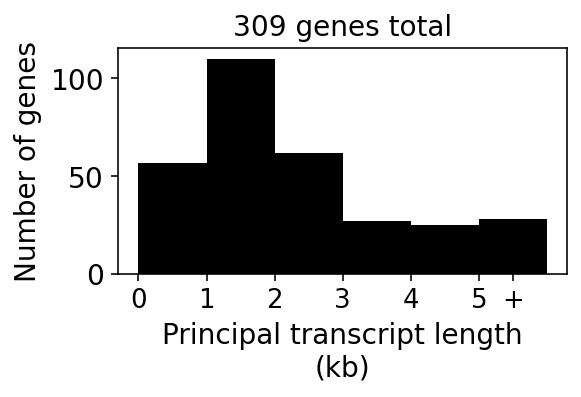

In [15]:
%matplotlib inline

fig,plots=plt.subplots(1)
fig.set_size_inches(4,2)

plots.hist(list(max_sizes_clipped['size']/1000),range(7),color='black')
plots.set_xlabel('Principal transcript length\n(kb)')
plots.set_ylabel('Number of genes')
plots.set_title(str(max_sizes_clipped.shape[0])+' genes total')
plots.set_xticks([0,1,2,3,4,5,5.5])
plots.set_xticklabels([0,1,2,3,4,5,'+'],fontsize=13)
plots.grid(False)


plt.savefig(FIGS+'/transcriptLen.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/transcriptLen.png',bbox_inches = "tight")
plt.show()

In [16]:
#computing the number of cells by size
def get_cells_accurate(max_sizes_clipped,transcript_length=999,cells_per_variant=10):
    of_interest=max_sizes_clipped.loc[max_sizes_clipped['size']<=transcript_length]
    codons=of_interest['size'].sum()/3
    amino_acids=20
    print('num variants (M)')
    print(codons*amino_acids/1000000)
    num_cells=codons*amino_acids*cells_per_variant
    #account for a 65% singlet rate
    num_cells=int(num_cells*1/0.65)
    print('length<',transcript_length,'bp | cells per variant',
          cells_per_variant,'| required total cells (M):',num_cells/1000000)
    
get_cells_accurate(max_sizes_clipped,
          transcript_length=999,cells_per_variant=10)
get_cells_accurate(max_sizes_clipped,
          transcript_length=1998,cells_per_variant=10)
get_cells_accurate(max_sizes_clipped,
          transcript_length=3000,cells_per_variant=10)

num variants (M)
0.27004
length< 999 bp | cells per variant 10 | required total cells (M): 4.154461
num variants (M)
1.3293
length< 1998 bp | cells per variant 10 | required total cells (M): 20.450769
num variants (M)
2.37022
length< 3000 bp | cells per variant 10 | required total cells (M): 36.464923


In [17]:
def compute_cost(num_cells,hashing=False):
    cost=0.55 
    #$0.33/cell for 10x 3', v3
    #plus $0.22/cell sequencing ($1750 per hiseq for 2 channels per hiseq, with 4000 cells/channel)
    
    if hashing:
        cost=0.21
        #13k cells/channel and 2 hiseqs, would be:
        #10x: 1250/13000=0.09
        #and sequencing: 1750/13000=0.13
        #=> $0.21/cell
        
    print('cells (M):',num_cells/1000000,'cost (M):',num_cells*cost/1000000)
  

In [18]:
#now compute with the actual lengths of the genes
m=1000000
compute_cost(4.1*m,hashing=True)
compute_cost(4.1*m,hashing=False)

m=1000000
compute_cost(36*m,hashing=True)
compute_cost(36*m,hashing=False)

cells (M): 4.1 cost (M): 0.8609999999999999
cells (M): 4.1 cost (M): 2.255
cells (M): 36.0 cost (M): 7.56
cells (M): 36.0 cost (M): 19.8


Power analysis
==

In [19]:
def read_in_scores(fname,PROTEIN,anno):
    scores=pd.read_csv(fname,index_col=0)

    scores['protein']=PROTEIN
    scores['group2']=list(scores.index)
    scores['cluster_color']='blue'#anno.loc[scores.index,'cluster_color']
    scores['log10_HotellingT2']=np.log10(scores['HotellingT2.mean'])
    scores['FDR.log10_HotellingT2']=scores['HotellingT2.q']
    scores['text_color']=anno.loc[scores.index,'text_color']
    scores['control_color']=anno.loc[scores.index,'control_color']
    scores['syn_unknown_hotspot']=anno.loc[scores.index,'control_status']
    scores.loc[scores['syn_unknown_hotspot']=='synonymous','syn_unknown_hotspot']
    scores['control_color2']=scores['control_color']
    colo='blue'
    if PROTEIN=='KRAS':
        colo='red'
    scores.loc[scores['control_color2']=='white','control_color2']=colo
    return(scores)

In [20]:
PROTEIN='TP53'
i=0
subs=1000

#anno====================
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
#anno_tp53=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.withresults.csv',sep='\t',index_col=0)
#anno_tp53=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.csv',sep='\t')
anno_tp53=pd.read_csv('/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/anno/'+PROTEIN+'.anno.withresults.csv',sep='\t',index_col=0)
#anno_tp53.index=anno_tp53['Variant']


#scores =================
ref='P359P'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
p53_scorefile=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
total_scores_tp53=read_in_scores(p53_scorefile,'TP53',anno_tp53)
total_scores_tp53['cluster_color']=anno_tp53.loc[total_scores_tp53['cluster_color'].index,'cluster_color']
print(total_scores_tp53.head())


            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.714310                 0.693012   
V173M               1.527210                 1.511067   
P47S                0.288396                 0.274315   
P152L               0.947292                 0.928515   
C176Y               1.422377                 1.407831   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.735607       0.000010        166.613473   
V173M                       1.543353       0.000010        373.069919   
P47S                        0.302478       0.444444         35.886533   
P152L                       0.966069       0.000010        117.255268   
C176Y                       1.436922       0.000010        246.055616   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  \
unassigned               154.356763                178.870184       0.000010   
V173M                    347.948070                398.191

In [21]:
PROTEIN='KRAS'

#anno====================
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
#anno_kras=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.csv',sep='\t')
anno_kras=pd.read_csv('/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/anno/'+PROTEIN+'.anno.withresults.csv',sep='\t',index_col=0)
#anno_kras.index=anno_kras['Variant']


#scores =================
ref='K169K'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
kras_scorefile=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
total_scores_kras=read_in_scores(kras_scorefile,'KRAS',anno_kras)
total_scores_kras['cluster_color']=anno_kras.loc[total_scores_kras['cluster_color'].index,'cluster_color']


[0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875]


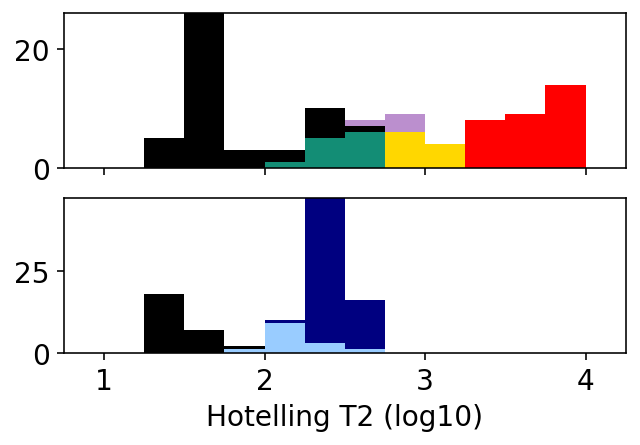

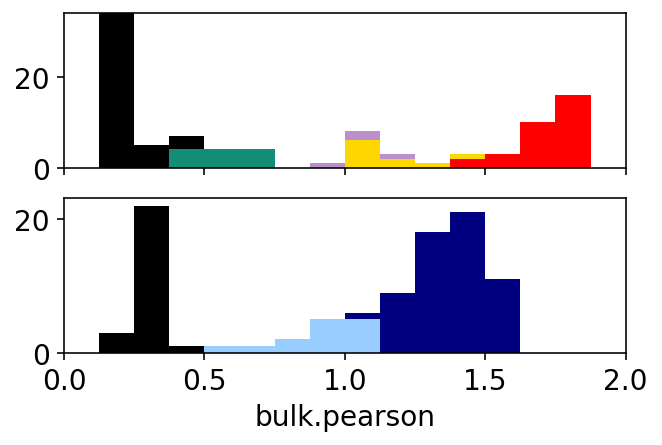

In [22]:
def plot_score_hist(total_scores_p53,
                   total_scores_kras,
                   method,colorname='cluster_color',
                   minbin=0,maxbin=5,num_bins=20,
                   scorename=''):
    
    #define the bins
    binsize=((maxbin-minbin)/num_bins)
    mybins=[x*binsize+minbin for x in range(num_bins)]
    print(mybins)
    
    fig,plots=plt.subplots(2,1)
    fig.set_size_inches(5,3)
    
    #TP53
    color_options=list(set(total_scores_p53[colorname]))
    scorelist=[]
    for i in range(len(color_options)):
        color=color_options[i]
        scorelist.append(total_scores_p53.loc[total_scores_p53[colorname]==color,method])
    a=plots[1].hist(scorelist,histtype='bar', stacked=True,color=color_options,bins=mybins)
    
    
    #KRAS
    color_options=list(set(total_scores_kras[colorname]))
    scorelist=[]
    for i in range(len(color_options)):
        color=color_options[i]
        scorelist.append(total_scores_kras.loc[total_scores_kras[colorname]==color,method])
    a=plots[0].hist(scorelist,histtype='bar', stacked=True,color=color_options,bins=mybins)
    plots[1].set_xlabel(scorename)
    plots[0].set_xticklabels([])
    
    for p_idx in range(2):
        plots[p_idx].grid(False)
        plots[p_idx].set_xlim(minbin,maxbin)


plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='log10_HotellingT2',colorname='cluster_color',
                   minbin=0.75,maxbin=4.25,num_bins=14,scorename='Hotelling T2 (log10)')

plt.savefig(FIGS+'/hist_scores.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/hist_scores.png',bbox_inches = "tight")

plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='avg.pearson.mean',colorname='cluster_color',
                   minbin=0,maxbin=2,num_bins=16,scorename='bulk.pearson')

In [23]:
mybins=[0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
binsize=0.25
#put the variants into bins here
method='log10_HotellingT2'
true_scores=pd.concat([total_scores_tp53,total_scores_kras])
true_scores.index=true_scores['protein']+true_scores['group2']
true_scores['bin']=-10
#true_scores['FDR.log10_HotellingT2']=true_scores['FDR.HotellingT2']

for mybin_idx in range(len(mybins)):
    mybin=mybins[mybin_idx]
    mybin_min=mybins[mybin_idx]
    mybin_max=mybins[mybin_idx]+binsize
    vars_here=[]
    for variant in list(true_scores.index):
        val=float(true_scores.loc[variant,method])
        if val>=mybin_min and val<mybin_max:
            vars_here.append(variant)
    true_scores.loc[vars_here,'bin']=mybin
print(true_scores.sort_values(by='bin').tail())

            avg.pearson.mean  avg.pearson.ci.0.95.low  \
KRASG12R            1.826844                 1.815557   
KRASAG11TD          1.814082                 1.805838   
KRASQ61L            1.824788                 1.810307   
KRASG13E            1.812674                 1.802993   
KRASQ61A            1.815147                 1.799215   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
KRASG12R                    1.838132        0.00001       6506.519146   
KRASAG11TD                  1.822326        0.00001       6328.460030   
KRASQ61L                    1.839270        0.00001       9515.380161   
KRASG13E                    1.822355        0.00001       8531.829617   
KRASQ61A                    1.831079        0.00001       5715.416856   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  \
KRASG12R                6277.833104               6735.205188        0.00001   
KRASAG11TD              6109.617456               6547.302

In [24]:
results=pd.DataFrame(columns=['method','subsampled_cells_per_variant','counts','effect_size_bin','auPRC','correct'])

SUBSAMPLING_LIST=[1000,900,800,700,600,500,400,300,200,
                  190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30,20,10]
ITERATIONS=range(10)

methods=['log10_HotellingT2']
FDR=0.05
counts=20000

for method in methods:
    for subs_idx,subs in enumerate(SUBSAMPLING_LIST):
        scores_iter_list=[]
        for iter_idx,iter_name in enumerate(ITERATIONS):
            scores_here_protein={}
            for PROTEIN in ['TP53','KRAS']:
                
                SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
                out_here=SCORE_DIR+'/scores.iter'+str(iter_name)+'.cells'+str(subs)+'.cells.csv'
                
                scores_here_protein[PROTEIN]=pd.read_csv(out_here,sep=',',header=0,index_col=0)
                scores_here_protein[PROTEIN]['group2']=list(scores_here_protein[PROTEIN].index)
                scores_here_protein[PROTEIN]['protein']=PROTEIN
                scores_here_protein[PROTEIN].index=scores_here_protein[PROTEIN]['protein']+scores_here_protein[PROTEIN]['group2']

            scores_here_iter=pd.concat([scores_here_protein['TP53'],
                                       scores_here_protein['KRAS']],axis=0)
            #scores_here_iter=scores_here_protein['KRAS']
            scores_here_iter['log10_HotellingT2']=np.log10(scores_here_iter['HotellingT2.mean'])
            scores_here_iter['FDR.log10_HotellingT2']=scores_here_iter['HotellingT2.q']
            scores_iter_list.append(scores_here_iter)
            
        scores_subs=pd.concat(scores_iter_list,axis=0)
        
        for mybin_idx in range(len(mybins)):
            mybin=mybins[mybin_idx]
            mybin_min=mybins[mybin_idx]
            mybin_max=mybins[mybin_idx]+binsize
            
            #subselect only the variants in this bin
            #bin_variants=list(true_scores.loc[true_scores['bin']==mybin,:].index)
            scores_subs['bin']=true_scores.loc[scores_subs.index,'bin']
            scores_subs_inbin=np.array(1.0*(scores_subs['bin']==mybin))
            passed_fdr=np.array(1.0*(scores_subs['FDR.'+str(method)]<=FDR))
            correct=np.sum(np.multiply(scores_subs_inbin,passed_fdr))/np.sum(scores_subs_inbin)
            
            results_here=pd.DataFrame({'method':method,
                                       'subsampled_cells_per_variant':subs,
                                       'counts':counts,
                                       'effect_size_bin':int(1000*mybin)/1000,
                                       'auPRC':np.nan,
                                      'correct':correct},
                                      index=[method+str(subs)+str(mybin)])
            results=pd.concat([results,results_here],axis=0)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [25]:
results['cells/variant']=results['subsampled_cells_per_variant']
results['sc-eVIP impact score']=results['effect_size_bin']
results2=results.pivot(index='sc-eVIP impact score',columns='cells/variant')['correct']
results2=results2.T
results2=results2.astype('float')
print(results2.head(40))

sc-eVIP impact score  0.75  1.00      1.25      1.50  1.75      2.00  \
cells/variant                                                          
10                     NaN   NaN  0.000000  0.003030  0.00  0.000000   
20                     NaN   NaN  0.000000  0.000000  0.00  0.007692   
30                     NaN   NaN  0.017391  0.009091  0.00  0.069231   
40                     NaN   NaN  0.000000  0.000000  0.00  0.015385   
50                     NaN   NaN  0.004348  0.000000  0.00  0.038462   
60                     NaN   NaN  0.000000  0.000000  0.02  0.092308   
70                     NaN   NaN  0.004348  0.000000  0.02  0.115385   
80                     NaN   NaN  0.000000  0.000000  0.02  0.269231   
90                     NaN   NaN  0.000000  0.000000  0.04  0.315385   
100                    NaN   NaN  0.000000  0.000000  0.02  0.338462   
110                    NaN   NaN  0.000000  0.000000  0.06  0.423077   
120                    NaN   NaN  0.000000  0.000000  0.08  0.44

In [26]:
results2=results2.loc[:,[2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75]]

In [27]:
results_below200=results2.loc[[200,
                  190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30,20,10][::-1],:]
results_above200=results2.loc[[1000,900,800,700,600,500,400,300,200][::-1],:]

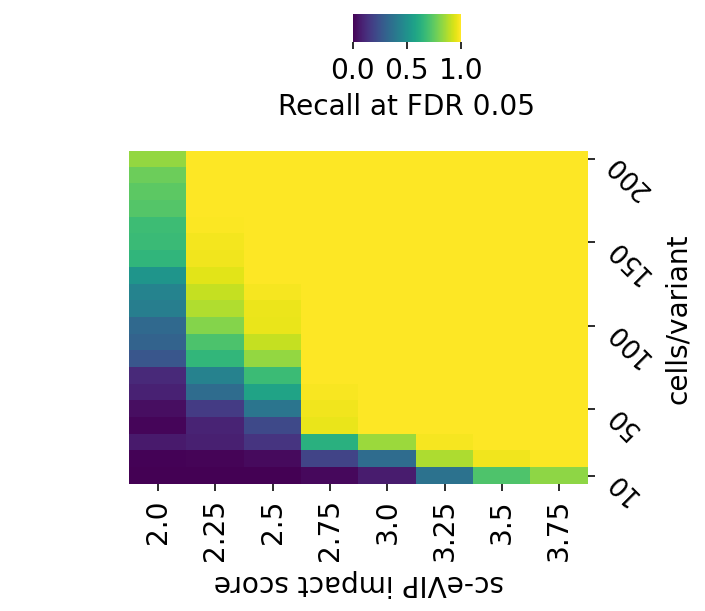

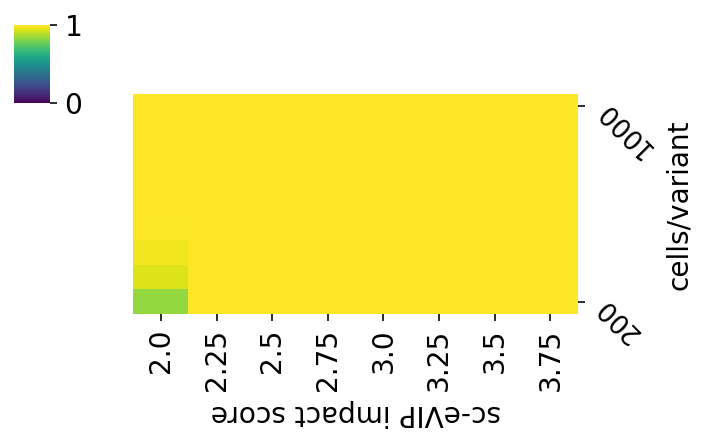

In [28]:
g=sns.clustermap(results_below200.iloc[::-1],cmap='viridis',col_cluster=False,row_cluster=False, #.T.iloc[:,::-1]
              yticklabels=True,figsize=(5,4),xticklabels=True,vmin=0,vmax=1,
                cbar_pos=(0.5, 1.0, 0.15, 0.05),
                 cbar_kws={'orientation':'horizontal',
                "label": "Recall at FDR 0.05",
                'ticks':[0,0.5,1]},)
g.ax_heatmap.set_yticks([0.5,5.5,10.5,15.5,19.5])
g.ax_heatmap.set_yticklabels([200,150,100,50,10], fontsize = 13,rotation=135)
g.ax_heatmap.set_xlabel('sc-eVIP impact score',rotation=180)
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.05.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.05.png',bbox_inches = "tight")
plt.show()

g=sns.clustermap(results_above200.iloc[::-1],cmap='viridis',col_cluster=False,row_cluster=False, #.T.iloc[:,::-1]
              yticklabels=True,figsize=(5,3),xticklabels=True,vmin=0,vmax=1,
                )
                #cbar_pos=(0.5, 1.0, 0.15, 0.05),
                 #cbar_kws={'orientation':'horizontal',
                #"label": "Recall at FDR 0.01",
                #'ticks':[0,0.5,1]},)
g.ax_heatmap.set_yticks([0.5,8.5])
g.ax_heatmap.set_yticklabels([1000,200], fontsize = 13,rotation=135)
g.ax_heatmap.set_xlabel('sc-eVIP impact score',rotation=180)
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.05.part2.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.05.part2.png',bbox_inches = "tight")
plt.show()

In [29]:
results2.loc[500,:]

sc-eVIP impact score
2.00    0.992308
2.25    1.000000
2.50    1.000000
2.75    1.000000
3.00    1.000000
3.25    1.000000
3.50    1.000000
3.75    1.000000
Name: 500, dtype: float64

In [30]:
results2[np.isnan(results2)]=0
results2.columns=[str(x) for x in list(results2.columns)]
print(results2.columns)

Index(['2.0', '2.25', '2.5', '2.75', '3.0', '3.25', '3.5', '3.75'], dtype='object')


In [31]:
DESIRED_POWER=0.95

#for each effect size bin -> get the number of cells you need
cells_per_bin=pd.DataFrame({'effect size bin':results2.columns,
                            'cells_needed':1000},index=results2.columns)

#define bins of effect size
for score_type in ['log10_HotellingT2']:

    #get the bins
    for mybin_idx in range(len(mybins)):
        mybin=mybins[mybin_idx]
        bin_min=mybins[mybin_idx]
        bin_max=mybins[mybin_idx]+binsize
        if str(bin_min) not in list(results2.columns):
            continue
        
        for i in range(results2.shape[0]):
            cur_power=float(list(results2[str(bin_min)])[i])
            cur_cells=1000
            #print(i,cur_power)
            if cur_power>=DESIRED_POWER:
                cur_cells=results2.index[i]
                break
        cells_per_bin.loc[str(bin_min),'cells_needed']=cur_cells

In [32]:
cells_per_bin['effect size bin'].iloc[1:(len(cells_per_bin['effect size bin'])-1)]

2.25    2.25
2.5      2.5
2.75    2.75
3.0      3.0
3.25    3.25
3.5      3.5
Name: effect size bin, dtype: object

In [33]:
cells_per_bin['cells_needed']

2.0     400
2.25    130
2.5     100
2.75     40
3.0      40
3.25     30
3.5      20
3.75     20
Name: cells_needed, dtype: int64

In [34]:
cells_per_bin

,effect size bin,cells_needed
2.0,2.0,400
2.25,2.25,130
2.5,2.5,100
2.75,2.75,40
3.0,3.0,40
3.25,3.25,30
3.5,3.5,20
3.75,3.75,20


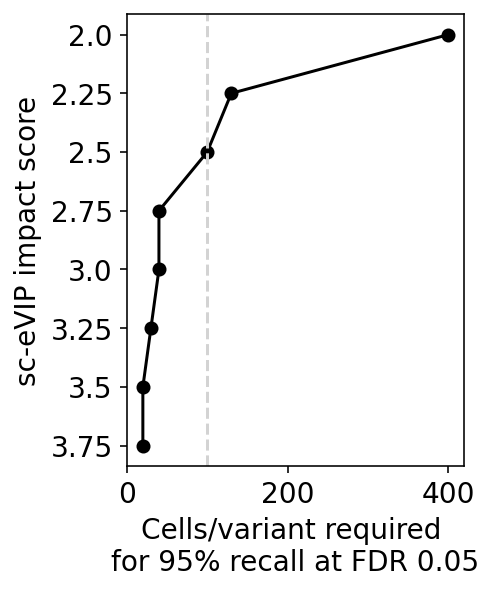

In [35]:
fig,plots=plt.subplots(1)
fig.set_size_inches(3,4)

plots.plot(
           cells_per_bin['cells_needed'][::-1],
    cells_per_bin['effect size bin'],
         color='black')
plots.scatter(
           cells_per_bin['cells_needed'][::-1],
    cells_per_bin['effect size bin'],
        color='black')
plots.set_xlabel('Cells/variant required \nfor 95% recall at FDR 0.05')
plots.set_ylabel('sc-eVIP impact score')
#plots.invert_yaxis()
#plots.set_yticks([0,100,200,300,400,500,600])
plots.grid(False)
plots.set_yticklabels(cells_per_bin['effect size bin'][::-1])
plots.axvline(x=100,linestyle='--',color='lightgray')
plots.set_xticks([0,200,400])

plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded.png',bbox_inches = "tight")
plt.show()

0        3250.0
1       32500.0
2      325000.0
3     3250000.0
4         650.0
5        6500.0
6       65000.0
7      650000.0
8         162.5
9        1625.0
10      16250.0
11     162500.0
Name: Number of variants, dtype: float64


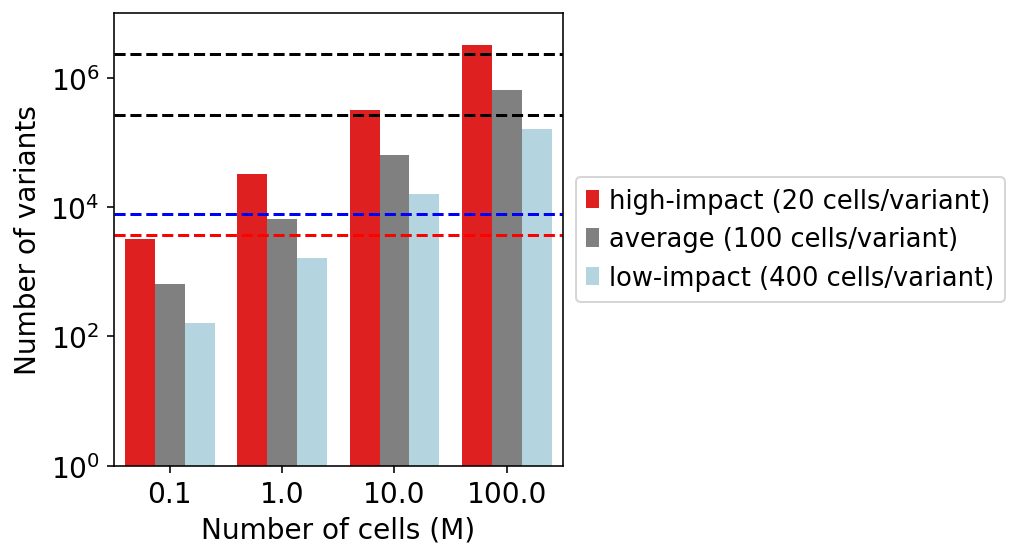

In [37]:
fig,plots=plt.subplots(1)
fig.set_size_inches(4,4)


counts=pd.DataFrame({'Number of cells':[100000,1000000,10000000,100000000,
                                        100000,1000000,10000000,100000000,
                                        100000,1000000,10000000,100000000],
                'Effect size':['high-impact (20 cells/variant)','high-impact (20 cells/variant)',
                               'high-impact (20 cells/variant)','high-impact (20 cells/variant)',
                                'average (100 cells/variant)','average (100 cells/variant)',
                               'average (100 cells/variant)','average (100 cells/variant)',
                                'low-impact (400 cells/variant)','low-impact (400 cells/variant)',
                               'low-impact (400 cells/variant)','low-impact (400 cells/variant)']})
counts['Number of cells (M)']=counts['Number of cells']/1000000
counts['Number of variants']=counts['Number of cells']/(20*(counts['Effect size']=='high-impact (20 cells/variant)')+
                                   400*(counts['Effect size']=='low-impact (400 cells/variant)')+
                                   100*(counts['Effect size']=='average (100 cells/variant)'))*0.65
print(counts['Number of variants'])

g=sns.barplot(data=counts,x='Number of cells (M)',y='Number of variants',hue='Effect size',#order=[100000,1000000],
           palette={'high-impact (20 cells/variant)':'red','low-impact (400 cells/variant)':'lightblue','average (100 cells/variant)':'gray'})
plt.grid(False)
plt.yscale('log')
plt.axhline(y=7860,linestyle='--',color='blue') #tp53
plt.axhline(y=3780,linestyle='--',color='red')  #kras
plt.axhline(y=270040,linestyle='--',color='black')  #1kb genes
plt.axhline(y=2370220,linestyle='--',color='black')  #3kb genes
plt.ylim(1,10000000)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(FIGS+'/PowerAnalysis_cellProjections.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_cellProjections.png',bbox_inches = "tight")


In [50]:
mybins=[0,0.1,0.2,.3,.4,.5,.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
x=1.0/8
mybins=[0,x,2*x,3*x,4*x,5*x,6*x,7*x,9*x,10*x,
       11*x,12*x,13*x,14*x,15*x,16*x]


In [52]:
binsize=0.25
#put the variants into bins here
method='avg.pearson.mean'
true_scores=pd.concat([total_scores_tp53,total_scores_kras])
true_scores.index=true_scores['protein']+true_scores['group2']
true_scores['bin']=-10
#true_scores['FDR.log10_HotellingT2']=true_scores['FDR.HotellingT2']

for mybin_idx in range(len(mybins)):
    mybin=mybins[mybin_idx]
    mybin_min=mybins[mybin_idx]
    mybin_max=mybins[mybin_idx]+binsize
    vars_here=[]
    for variant in list(true_scores.index):
        val=float(true_scores.loc[variant,method])
        if val>=mybin_min and val<mybin_max:
            vars_here.append(variant)
    true_scores.loc[vars_here,'bin']=mybin
print(true_scores.sort_values(by='bin').tail())

           avg.pearson.mean  avg.pearson.ci.0.95.low  \
KRASG12I           1.825685                 1.816386   
KRASG12V           1.803434                 1.794195   
KRASG12C           1.772643                 1.760321   
KRASQ61H           1.834963                 1.823591   
KRASA146T          1.772699                 1.758633   

           avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
KRASG12I                   1.834983        0.00001       7577.673193   
KRASG12V                   1.812673        0.00001       5032.273970   
KRASG12C                   1.784964        0.00001       5284.767257   
KRASQ61H                   1.846335        0.00001       7313.391930   
KRASA146T                  1.786766        0.00001       7566.469832   

           HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  \
KRASG12I               7293.881435               7861.464951        0.00001   
KRASG12V               4870.763820               5193.784121        0.00

In [56]:
results=pd.DataFrame(columns=['method','subsampled_cells_per_variant','counts','effect_size_bin','auPRC','correct'])

SUBSAMPLING_LIST=[1000,900,800,700,600,500,400,300,200,
                  190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30]
ITERATIONS=range(10)

methods=['avg.pearson']
FDR=0.01
counts=20000

for method in methods:
    for subs_idx,subs in enumerate(SUBSAMPLING_LIST):
        scores_iter_list=[]
        for iter_idx,iter_name in enumerate(ITERATIONS):
            scores_here_protein={}
            for PROTEIN in ['TP53','KRAS']:
                
                SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
                out_here=SCORE_DIR+'/scores.iter'+str(iter_name)+'.cells'+str(subs)+'.cells.csv'
                
                scores_here_protein[PROTEIN]=pd.read_csv(out_here,sep=',',header=0,index_col=0)
                scores_here_protein[PROTEIN]['protein']=PROTEIN
                scores_here_protein[PROTEIN]['group2']=list(scores_here_protein[PROTEIN].index)
                scores_here_protein[PROTEIN].index=scores_here_protein[PROTEIN]['protein']+scores_here_protein[PROTEIN]['group2']

            scores_here_iter=pd.concat([scores_here_protein['TP53'],
                                       scores_here_protein['KRAS']],axis=0)
            #scores_here_iter=scores_here_protein['KRAS']
            scores_iter_list.append(scores_here_iter)
            
        scores_subs=pd.concat(scores_iter_list,axis=0)
        
        for mybin_idx in range(len(mybins)):
            mybin=mybins[mybin_idx]
            mybin_min=mybins[mybin_idx]
            mybin_max=mybins[mybin_idx]+binsize
            
            #subselect only the variants in this bin
            #bin_variants=list(true_scores.loc[true_scores['bin']==mybin,:].index)
            scores_subs['bin']=true_scores.loc[scores_subs.index,'bin']
            scores_subs_inbin=np.array(1.0*(scores_subs['bin']==mybin))
            passed_fdr=np.array(1.0*(scores_subs[str(method)+'.q']<=FDR))
            correct=np.sum(np.multiply(scores_subs_inbin,passed_fdr))/np.sum(scores_subs_inbin)
            
            results_here=pd.DataFrame({'method':method,
                                       'subsampled_cells_per_variant':subs,
                                       'counts':counts,
                                       'effect_size_bin':int(1000*mybin)/1000,
                                       'auPRC':np.nan,
                                      'correct':correct},
                                      index=[method+str(subs)+str(mybin)])
            results=pd.concat([results,results_here],axis=0)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [57]:
results['cells/variant']=results['subsampled_cells_per_variant']
results['sc-eVIP impact score']=results['effect_size_bin']
results2=results.pivot(index='sc-eVIP impact score',columns='cells/variant')['correct']
results2=results2.T
results2=results2.astype('float')
print(results2.head(40))

sc-eVIP impact score  0.000     0.125     0.250   0.375  0.500  0.625  0.750  \
cells/variant                                                                  
30                      NaN  0.002703  0.018519  0.0125   0.02   0.08   0.10   
40                      NaN  0.000000  0.007407  0.0250   0.02   0.24   0.15   
50                      NaN  0.000000  0.007407  0.0875   0.14   0.30   0.20   
60                      NaN  0.000000  0.014815  0.1000   0.16   0.34   0.30   
70                      NaN  0.000000  0.007407  0.1125   0.28   0.44   0.45   
80                      NaN  0.000000  0.011111  0.1750   0.38   0.52   0.50   
90                      NaN  0.000000  0.025926  0.1750   0.34   0.66   0.40   
100                     NaN  0.000000  0.018519  0.1875   0.48   0.70   0.55   
110                     NaN  0.000000  0.022222  0.2000   0.52   0.80   0.65   
120                     NaN  0.000000  0.033333  0.3125   0.66   0.80   0.55   
130                     NaN  0.000000  0

In [58]:
results2=results2.loc[:,[3*x,4*x,5*x,6*x,7*x,9*x,10*x,
       11*x,12*x]]

In [59]:
results_below200=results2.loc[[200,
                  190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30][::-1],:]
results_above200=results2.loc[[1000,900,800,700,600,500,400,300,200][::-1],:]

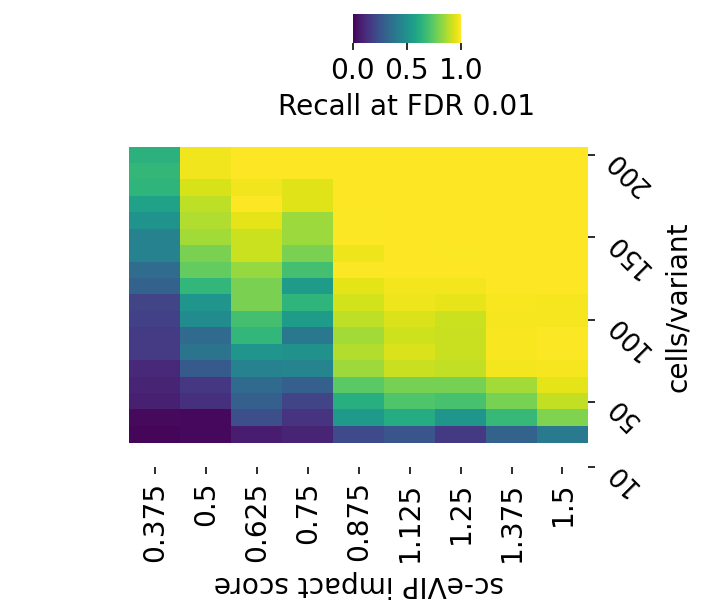

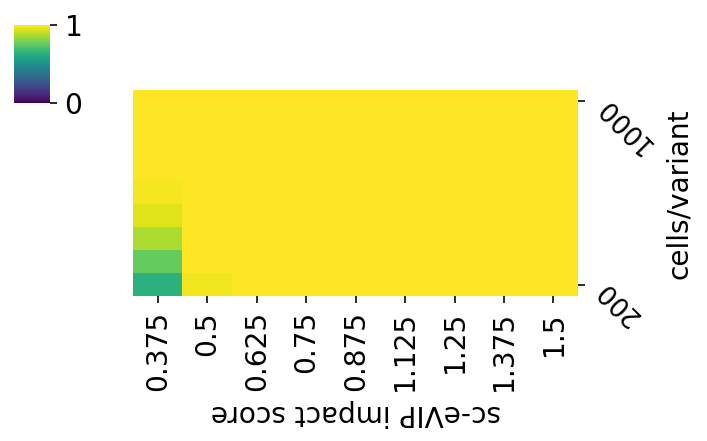

In [60]:
g=sns.clustermap(results_below200.iloc[::-1],cmap='viridis',col_cluster=False,row_cluster=False, #.T.iloc[:,::-1]
              yticklabels=True,figsize=(5,4),xticklabels=True,vmin=0,vmax=1,
                cbar_pos=(0.5, 1.0, 0.15, 0.05),
                 cbar_kws={'orientation':'horizontal',
                "label": "Recall at FDR 0.01",
                'ticks':[0,0.5,1]},)
g.ax_heatmap.set_yticks([0.5,5.5,10.5,15.5,19.5])
g.ax_heatmap.set_yticklabels([200,150,100,50,10], fontsize = 13,rotation=135)
g.ax_heatmap.set_xlabel('sc-eVIP impact score',rotation=180)
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.png',bbox_inches = "tight")
plt.show()

g=sns.clustermap(results_above200.iloc[::-1],cmap='viridis',col_cluster=False,row_cluster=False, #.T.iloc[:,::-1]
              yticklabels=True,figsize=(5,3),xticklabels=True,vmin=0,vmax=1,
                )
                #cbar_pos=(0.5, 1.0, 0.15, 0.05),
                 #cbar_kws={'orientation':'horizontal',
                #"label": "Recall at FDR 0.01",
                #'ticks':[0,0.5,1]},)
g.ax_heatmap.set_yticks([0.5,8.5])
g.ax_heatmap.set_yticklabels([1000,200], fontsize = 13,rotation=135)
g.ax_heatmap.set_xlabel('sc-eVIP impact score',rotation=180)
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.part2.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.part2.png',bbox_inches = "tight")
plt.show()

In [61]:
true_scores.loc[['KRAST50P','KRAST20R'],:]

,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,avg.pearson.q,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,HotellingT2.q,protein,group2,cluster_color,log10_HotellingT2,FDR.log10_HotellingT2,text_color,control_color,syn_unknown_hotspot,control_color2,bin
KRAST50P,0.464966,0.450968,0.478964,0.00001,231.276046,211.254054,251.298039,0.00001,KRAS,T50P,#138D75,2.364131,0.00001,black,white,unknown,red,0.375
KRAST20R,0.577729,0.550415,0.605043,0.00001,222.549192,202.711919,242.386465,0.00001,KRAS,T20R,#138D75,2.347426,0.00001,black,white,unknown,red,0.500


In [62]:
results2.loc[500,:]

sc-eVIP impact score
0.375    0.95
0.500    1.00
0.625    1.00
0.750    1.00
0.875    1.00
1.125    1.00
1.250    1.00
1.375    1.00
1.500    1.00
Name: 500, dtype: float64

In [63]:
results2[np.isnan(results2)]=0
results2.columns=[str(x) for x in list(results2.columns)]
print(results2.columns)

Index(['0.375', '0.5', '0.625', '0.75', '0.875', '1.125', '1.25', '1.375',
       '1.5'],
      dtype='object')


In [64]:
DESIRED_POWER=0.95

#for each effect size bin -> get the number of cells you need
cells_per_bin=pd.DataFrame({'effect size bin':results2.columns,
                            'cells_needed':1000},index=results2.columns)

#define bins of effect size
for score_type in ['log10_HotellingT2']:

    #get the bins
    for mybin_idx in range(len(mybins)):
        mybin=mybins[mybin_idx]
        bin_min=mybins[mybin_idx]
        bin_max=mybins[mybin_idx]+binsize
        if str(bin_min) not in list(results2.columns):
            continue
        
        for i in range(results2.shape[0]):
            cur_power=float(list(results2[str(bin_min)])[i])
            cur_cells=1000
            #print(i,cur_power)
            if cur_power>=DESIRED_POWER:
                cur_cells=results2.index[i]
                break
        cells_per_bin.loc[str(bin_min),'cells_needed']=cur_cells

In [65]:
cells_per_bin['effect size bin'].iloc[1:(len(cells_per_bin['effect size bin'])-1)]

0.5        0.5
0.625    0.625
0.75      0.75
0.875    0.875
1.125    1.125
1.25      1.25
1.375    1.375
Name: effect size bin, dtype: object

In [66]:
cells_per_bin['cells_needed']

0.375    500
0.5      190
0.625    160
0.75     170
0.875    120
1.125    110
1.25     110
1.375     70
1.5       60
Name: cells_needed, dtype: int64

In [67]:
cells_per_bin

,effect size bin,cells_needed
0.375,0.375,500
0.5,0.5,190
0.625,0.625,160
0.75,0.75,170
0.875,0.875,120
1.125,1.125,110
1.25,1.25,110
1.375,1.375,70
1.5,1.5,60


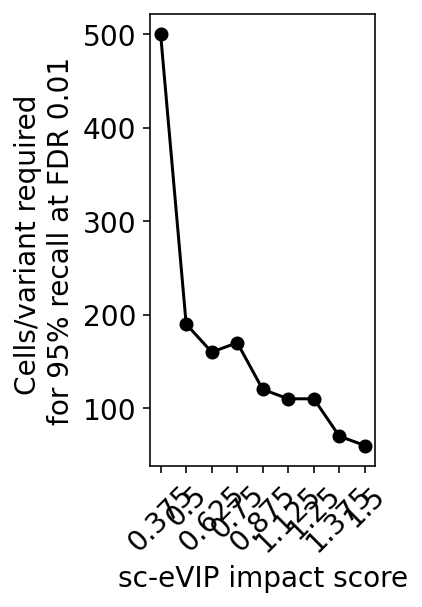

In [68]:
fig,plots=plt.subplots(1)
fig.set_size_inches(2,4)

plots.plot(cells_per_bin['effect size bin'],
           cells_per_bin['cells_needed'],
         color='black')
plots.scatter(cells_per_bin['effect size bin'],
           cells_per_bin['cells_needed'],
        color='black')
plots.set_ylabel('Cells/variant required \nfor 95% recall at FDR 0.01')
plots.set_xlabel('sc-eVIP impact score')
#plots.invert_yaxis()
#plots.set_yticks([0,100,200,300,400,500,600])
plots.grid(False)
plots.set_xticklabels(cells_per_bin['effect size bin'],
                      rotation=45)

plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded.png',bbox_inches = "tight")
plt.show()

In [69]:
#heatmap cells per number of variants
multipliers=[1,10,100,1000,10000,100000,1000000,10000000]

#heatmap cells per number of variants
multipliers=range(300,1000)
cells_per_bin_by_variant=pd.DataFrame(index=cells_per_bin['effect size bin'],
                                     columns=multipliers)
to_remove=[]
for m in multipliers:
    multiplier=np.power(10,m/150)
    if multiplier>50000000:
        to_remove.append(m)
        continue
    
    cells_per_bin_by_variant.loc[:,m]=multiplier*cells_per_bin['cells_needed']*1/0.65
    print(m,multiplier)

300 100.0
301 101.54689924330806
302 103.11772745930548
303 104.71285480508996
304 106.33265716371616
305 107.97751623277094
306 109.64781961431851
307 111.34396090623619
308 113.06633979496387
309 114.81536214968828
310 116.59144011798323
311 118.39499222293017
312 120.22644346174131
313 122.08622540590706
314 123.97477630289441
315 125.89254117941675
316 127.8399719463023
317 129.8175275049849
318 131.82567385564073
319 133.86488420699928
320 135.93563908785256
321 138.03842646028852
322 140.17374183467695
323 142.34208838643414
324 144.5439770745928
325 146.7799267622069
326 149.0504643386196
327 151.35612484362088
328 153.6974515935271
329 156.07499630921114
330 158.48931924611142
331 160.94098932625346
332 163.43058427231378
333 165.95869074375614
334 168.5259044750751
335 171.1328304161781
336 173.78008287493762
337 176.46828566194998
338 179.1980722375334
339 181.97008586099827
340 184.78497974222907
341 187.64341719560858
342 190.54607179632464
343 193.49362753909523
344 196.48

In [70]:
cells_per_bin_by_variant[955]

effect size bin
0.375    1.789465e+09
0.5      6.799969e+08
0.625    5.726289e+08
0.75     6.084182e+08
0.875    4.294717e+08
1.125    3.936824e+08
1.25     3.936824e+08
1.375    2.505252e+08
1.5      2.147359e+08
Name: 955, dtype: float64

In [71]:
#heatmap cells per number of variants
multipliers=[1,10,100,1000,10000,100000,1000000,270000,2300000,10000000]

#heatmap cells per number of variants
cells_per_bin_by_variant=pd.DataFrame(index=cells_per_bin['effect size bin'],
                                     columns=multipliers)
to_remove=[]
for m in multipliers:
    multiplier=m
    
    cells_per_bin_by_variant.loc[:,m]=multiplier*cells_per_bin['cells_needed']*1/0.65
    print(m,multiplier)

1 1
10 10
100 100
1000 1000
10000 10000
100000 100000
1000000 1000000
270000 270000
2300000 2300000
10000000 10000000


In [72]:
cells_per_bin_by_variant

,1,10,100,1000,10000,100000,1000000,270000,2300000,10000000
effect size bin,,,,,,,,,,
0.375,769.230769,7692.307692,76923.076923,769230.769231,7.692308e+06,7.692308e+07,7.692308e+08,2.076923e+08,1.769231e+09,7.692308e+09
0.5,292.307692,2923.076923,29230.769231,292307.692308,2.923077e+06,2.923077e+07,2.923077e+08,7.892308e+07,6.723077e+08,2.923077e+09
0.625,246.153846,2461.538462,24615.384615,246153.846154,2.461538e+06,2.461538e+07,2.461538e+08,6.646154e+07,5.661538e+08,2.461538e+09
0.75,261.538462,2615.384615,26153.846154,261538.461538,2.615385e+06,2.615385e+07,2.615385e+08,7.061538e+07,6.015385e+08,2.615385e+09
0.875,184.615385,1846.153846,18461.538462,184615.384615,1.846154e+06,1.846154e+07,1.846154e+08,4.984615e+07,4.246154e+08,1.846154e+09
1.125,169.230769,1692.307692,16923.076923,169230.769231,1.692308e+06,1.692308e+07,1.692308e+08,4.569231e+07,3.892308e+08,1.692308e+09
1.25,169.230769,1692.307692,16923.076923,169230.769231,1.692308e+06,1.692308e+07,1.692308e+08,4.569231e+07,3.892308e+08,1.692308e+09
1.375,107.692308,1076.923077,10769.230769,107692.307692,1.076923e+06,1.076923e+07,1.076923e+08,2.907692e+07,2.476923e+08,1.076923e+09
1.5,92.307692,923.076923,9230.769231,92307.692308,9.230769e+05,9.230769e+06,9.230769e+07,2.492308e+07,2.123077e+08,9.230769e+08


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if

KeyError: 815

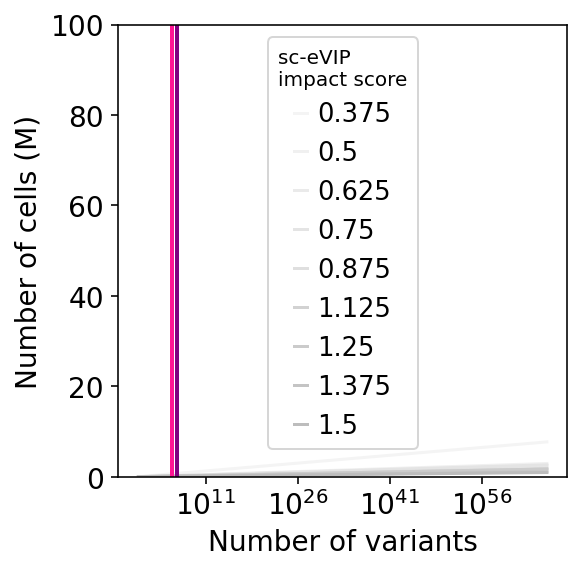

In [74]:
df=cells_per_bin_by_variant.T

import matplotlib.cm as cm
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys)

fig,plots=plt.subplots(1,1)
fig.set_size_inches(4,4)
for effect_size in df.columns:
    col=mapper.to_rgba(float(effect_size))
    plots.plot(np.power(10,df.index/150),df[str(effect_size)]/1000000,c=col,label=str(effect_size))
    #plots.plot(multipliers,1.0*df.loc[:,effect_size]/1000000,c=col,label=str(effect_size))
    plots.set_xscale('log')
    plots.grid(False)
    plots.set_ylim(0,100)
    #plots.set_xlim(1,4000000)
    plots.set_xlabel('Number of variants')
    plots.set_ylabel('Number of cells (M)')
    plots.legend(title='sc-eVIP \nimpact score')
    #plots.set_xlim(100,max(np.power(10,df.index/150)))
    c1='purple'
    c2='deeppink'
    plots.axvline(x=2300000,color=c1,lw=2)#,linestyle='--')
    plots.axvline(x=270000,color=c2,lw=2)#,linestyle='--')
plots.scatter([270000],[df.loc[815,str(3.75)]/1000000],color=c2,s=100)
plots.scatter([2300000],[df.loc[955,str(3.75)]/1000000],color=c1,s=100)

plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded_byNumVariants.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded_byNumVariants.png',bbox_inches = "tight")
plt.show()

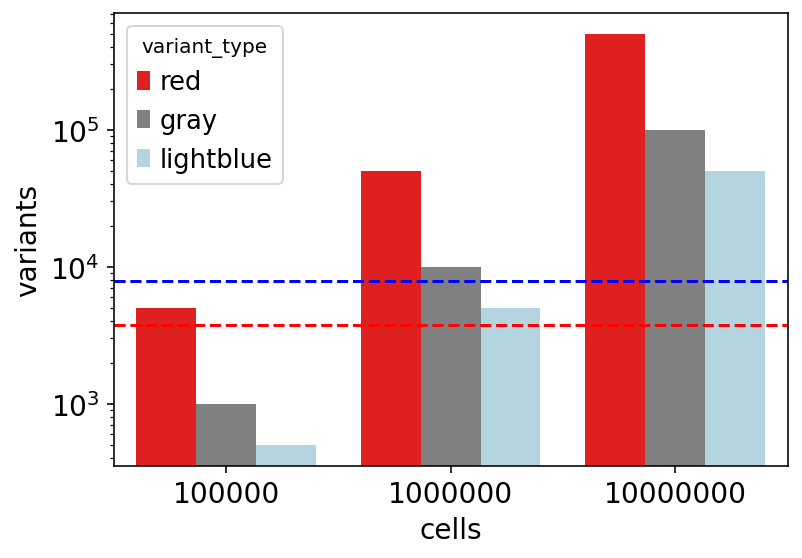

In [53]:
counts=pd.DataFrame({'cells':[100000,1000000,10000000,100000,1000000,10000000,100000,1000000,10000000],
                'variant_type':['red','red','red','gray','gray','gray','lightblue','lightblue','lightblue'],
                'variants':np.array([5000,50000,500000,1000,10000,100000,500,5000,50000])})
sns.barplot(data=counts,x='cells',y='variants',hue='variant_type',#order=[100000,1000000],
           palette={'red':'red','lightblue':'lightblue','gray':'gray'})
plt.grid(False)
plt.yscale('log')
plt.axhline(y=7860,linestyle='--',color='blue')
plt.axhline(y=3780,linestyle='--',color='red')